In [ ]:
import numpy as np
import pandas as pd

# Sentiment Analysis

In [ ]:
from textblob import TextBlob

def get_sentiment_score(text):
    # Handle NaN values by converting them to empty strings
    if pd.isna(text):
        text = ""
    analysis = TextBlob(text)
    # The sentiment score ranges from -1 (negative) to 1 (positive)
    return analysis.sentiment.polarity

In [ ]:
# Apply sentiment analysis to both 'review/Summary' and 'review/Text'
cleaned_ratings['sentiment_score'] = cleaned_ratings.apply(
    lambda row: (get_sentiment_score(row['review/Summary']) +
                 get_sentiment_score(row['review/Text'])) / 2,
    axis=1
)

In [ ]:
def categorize_sentiment(score):
    if score >= 0.6:
        return 'excellent'
    elif score >= 0.2:
        return 'good'
    elif score >= -0.2:
        return 'average'
    elif score >= -0.6:
        return 'bad'
    else:
        return 'worse'

cleaned_ratings['sentiment_category'] = cleaned_ratings['sentiment_score'].apply(categorize_sentiment)
cleaned_ratings.head()

,Title,Price,review/score,review/Summary,review/Text,profileName,sentiment_score,sentiment_category
0,Its Only Art If Its Well Hung!,NaN,4.0,nice collect juli strain imag,juli strain fan collect photo page worth nice ...,"Jim of Oz ""jim-of-oz""",0.412500,good
1,Dr. Seuss: American Icon,NaN,5.0,realli enjoy,dont care much dr seuss read philip nel book c...,Kevin Killian,0.370265,good
2,Dr. Seuss: American Icon,NaN,5.0,essenti everi person public librari,peopl becom book read child father man dr seus...,John Granger,0.105177,average
3,Dr. Seuss: American Icon,NaN,4.0,phlip nel give silli seuss seriou treatment,theodor seuss geisel aka quotdr seussquot one ...,"Roy E. Perry ""amateur philosopher""",0.067130,average
4,Dr. Seuss: American Icon,NaN,4.0,good academ overview,philip nel dr seuss american iconthi basic aca...,"D. H. Richards ""ninthwavestore""",0.448455,good


In [ ]:
# Calculate sentiment category counts
sentiment_counts = cleaned_ratings['sentiment_category'].value_counts()
sentiment_counts

sentiment_category
average      1851532
good          914078
excellent     149626
bad            59815
worse           2142
Name: count, dtype: int64

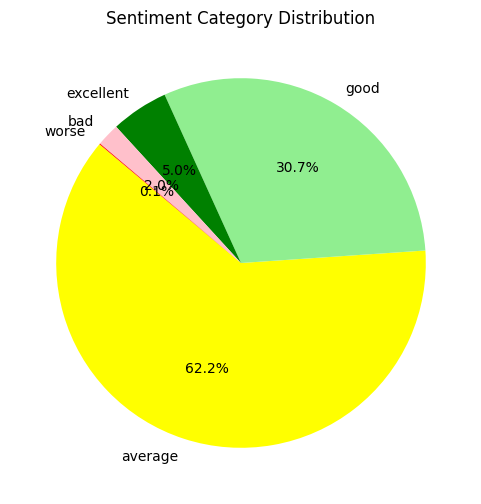

In [ ]:
import matplotlib.pyplot as plt

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['yellow', 'lightgreen', 'green', 'pink', 'red'])
plt.title('Sentiment Category Distribution')
plt.show()

In [ ]:
cleaned_ratings.to_csv("ratings_with_sentiment_analysis.csv")

# Latent Dirichlet Allocation (LDA)

In [ ]:
cleaned_ratings = pd.read_csv('/kaggle/input/book-ratings-with-sentiment-analysis/ratings with sentiment analysis.csv')
cleaned_ratings.head()

,Unnamed: 0,Title,Price,review/score,review/Summary,review/Text,profileName,sentiment_score,sentiment_category
0,0,Its Only Art If Its Well Hung!,NaN,4.0,nice collect juli strain imag,juli strain fan collect photo page worth nice ...,"Jim of Oz ""jim-of-oz""",0.412500,good
1,1,Dr. Seuss: American Icon,NaN,5.0,realli enjoy,dont care much dr seuss read philip nel book c...,Kevin Killian,0.370265,good
2,2,Dr. Seuss: American Icon,NaN,5.0,essenti everi person public librari,peopl becom book read child father man dr seus...,John Granger,0.105177,average
3,3,Dr. Seuss: American Icon,NaN,4.0,phlip nel give silli seuss seriou treatment,theodor seuss geisel aka quotdr seussquot one ...,"Roy E. Perry ""amateur philosopher""",0.067130,average
4,4,Dr. Seuss: American Icon,NaN,4.0,good academ overview,philip nel dr seuss american iconthi basic aca...,"D. H. Richards ""ninthwavestore""",0.448455,good


In [ ]:
cleaned_ratings.drop('Unnamed: 0', axis = 1, inplace = True)
cleaned_ratings.shape

(2977193, 8)

In [ ]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
import string

# Tokenize, remove stopwords, and punctuation
def preprocess(text):
    if isinstance(text, list):
        text = ' '.join(text)  # Join list if already tokenized
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())  # Tokenize and lowercase
        tokens = [word for word in tokens if word not in string.punctuation]  # Remove punctuation
        return tokens
    else:
        return []  # Return empty list if input is not string

# Define the size of each chunk (e.g., 50,000 rows per chunk)
chunk_size = 50000

# Split the dataset into chunks
chunks = [cleaned_ratings[i:i + chunk_size] for i in range(0, cleaned_ratings.shape[0], chunk_size)]

# Iterate over each chunk, process it, and store the results
for idx, chunk in enumerate(chunks):
    print(f'Processing chunk {idx + 1} of {len(chunks)}...')

    # Preprocess the text data
    chunk = chunk.copy()  # Make a copy to avoid warnings
    chunk['review/Text'] = chunk['review/Text'].fillna('').apply(preprocess)

    # Filter out rows where 'review/Text' is empty after preprocessing
    chunk = chunk[chunk['review/Text'].apply(len) > 0]

    # Create a dictionary and corpus for the chunk
    dictionary = corpora.Dictionary(chunk['review/Text'])
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in chunk['review/Text']]

    # Ensure the corpus has valid entries
    if len(corpus) > 0:
        # Train the LDA model on the chunk
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)

        # Get the dominant topic for each review in the chunk
        def get_dominant_topic(lda_model, bow):
            topics = lda_model.get_document_topics(bow)
            return max(topics, key=lambda x: x[1])[0] if topics else None

        chunk['dominant_topic'] = [get_dominant_topic(lda_model, bow) for bow in corpus]

    # Save each chunk's result to a CSV file
    chunk.to_csv(f'chunk_{idx}_results.csv', index=False)

# Combine all chunk results into one DataFrame
combined_df = pd.concat([pd.read_csv(f'chunk_{i}_results.csv') for i in range(len(chunks))], ignore_index=True)

# Save the combined results to a new CSV file
combined_df.to_csv('combined_topic_results.csv', index=False)

# Print a preview of the combined results
print(combined_df[['Title', 'dominant_topic']].head())

Processing chunk 1 of 60...
Processing chunk 2 of 60...
Processing chunk 3 of 60...
Processing chunk 4 of 60...
Processing chunk 5 of 60...
Processing chunk 6 of 60...
Processing chunk 7 of 60...
Processing chunk 8 of 60...
Processing chunk 9 of 60...
Processing chunk 10 of 60...
Processing chunk 11 of 60...
Processing chunk 12 of 60...
Processing chunk 13 of 60...
Processing chunk 14 of 60...
Processing chunk 15 of 60...
Processing chunk 16 of 60...
Processing chunk 17 of 60...
Processing chunk 18 of 60...
Processing chunk 19 of 60...
Processing chunk 20 of 60...
Processing chunk 21 of 60...
Processing chunk 22 of 60...
Processing chunk 23 of 60...
Processing chunk 24 of 60...
Processing chunk 25 of 60...
Processing chunk 26 of 60...
Processing chunk 27 of 60...
Processing chunk 28 of 60...
Processing chunk 29 of 60...
Processing chunk 30 of 60...
Processing chunk 31 of 60...
Processing chunk 32 of 60...
Processing chunk 33 of 60...
Processing chunk 34 of 60...
Processing chunk 35 of 

In [ ]:
def get_topic_descriptions(lda_model, num_words=5):
    topic_descriptions = {}
    for topic_id, topic in lda_model.show_topics(formatted=False, num_words=num_words):
        topic_descriptions[topic_id] = " ".join([word for word, prop in topic])
    return topic_descriptions

topic_descriptions = get_topic_descriptions(lda_model)
topic_descriptions

{0: 'jane love like stori one',
 1: 'stori adventur classic one great',
 2: 'novel life stori charact man',
 3: 'war histori american america polit',
 4: 'one use work mani author'}

In [ ]:
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

# Prepare the visualization data
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
pyLDAvis.save_html(lda_display, 'lda_visualization.html')